<a href="https://colab.research.google.com/github/andreacharlota/Motorcycle-Web-Development/blob/main/Clustering_Grizzer_Animal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop2.7.tgz  
!tar -xvf spark-3.2.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.2.0-bin-hadoop2.7/
spark-3.2.0-bin-hadoop2.7/NOTICE
spark-3.2.0-bin-hadoop2.7/kubernetes/
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/python_executable_check.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/autoscale.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/worker_memory_check.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/py_container_checks.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/decommissioning.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/pyfiles.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/decommissioning_cleanup.py
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/decom.sh
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/
spark-3.2.0-bin-hadoop2.7/kubernetes/docker

In [16]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
df_train = spark.read.option("inferSchema", "true").csv("BearTraining.csv", header = True)
df_test = spark.read.option("inferSchema", "true").csv("BearTesting.csv", header = True)

df_train.show(5)
df_test.show(5)

+------+-----------+------------------+----------+---------+------+
|Weight|Front Claws|Pupillary Distance|Hair Color|Ear Shape|Length|
+------+-----------+------------------+----------+---------+------+
|   399|        9.0|              12.0|Dark Brown|  Rounded|   9.6|
|   210|        9.6|              10.7|     Black|    Broad|   5.2|
|   488|        1.4|              15.1|     Blond|    Broad|   5.0|
|   451|        5.4|              12.3|     Black|    Broad|   8.9|
|   372|        3.5|               9.0|     White|  Pointed|   7.9|
+------+-----------+------------------+----------+---------+------+
only showing top 5 rows

+------+-----------+------------------+-----------+---------+------+-------+
|Weight|Front Claws|Pupillary Distance| Hair Color|Ear Shape|Length|Grizzly|
+------+-----------+------------------+-----------+---------+------+-------+
|   225|        3.7|              11.3|      Blond|  Rounded|   6.7|     No|
|   489|        7.8|              12.0|      Black|  Ro

In [17]:
import matplotlib.pyplot as plt


In [18]:
# read csv
testing = spark.read.csv("BearTesting.csv", header=True, inferSchema=True)
training = spark.read.csv("BearTraining.csv", header=True, inferSchema=True)

In [19]:
# drop null values
training = training.na.drop()
testing = testing.na.drop()

In [20]:
# select column
columns = ["Front Claws", "Pupillary Distance", "Ear Shape"]

testing = testing.select("Front Claws", "Pupillary Distance", "Ear Shape", "Grizzly")
training = training.select(columns)

In [21]:
# data transform
from pyspark.sql.functions import when

testing = testing.withColumn(
    "Ear Shape",
    when(testing["Ear Shape"] == "Pointed", 0)
      .when(testing["Ear Shape"] == "Broad", 1)
      .otherwise(2)
)

testing = testing.withColumn(
    "Grizzly",
    when(testing["Grizzly"] == "No",0)
    .otherwise(1)
)

training = training.withColumn(
    "Ear Shape",
    when(training["Ear Shape"] == "Pointed", 0)
    .when(training["Ear Shape"] == "Broad", 1)
    .otherwise(2)
)

testing.show()

+-----------+------------------+---------+-------+
|Front Claws|Pupillary Distance|Ear Shape|Grizzly|
+-----------+------------------+---------+-------+
|        3.7|              11.3|        2|      0|
|        7.8|              12.0|        2|      1|
|        5.1|              11.1|        1|      1|
|        9.1|              11.8|        0|      0|
|        4.6|              12.4|        1|      0|
|        2.9|              10.4|        1|      0|
|        4.9|              11.3|        1|      0|
|        3.1|              10.7|        1|      0|
|        1.7|               9.4|        2|      1|
|        1.5|              10.4|        0|      0|
|        4.0|              10.1|        1|      1|
|        3.1|              12.9|        1|      0|
|        5.5|              13.2|        0|      1|
|        7.1|              16.3|        2|      1|
|        5.2|               8.6|        1|      0|
|        4.9|              10.1|        2|      1|
|        2.3|              11.1

In [22]:
# normalize data
from pyspark.ml.feature import VectorAssembler, StandardScaler
assembler = VectorAssembler(inputCols=columns,outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")

testing = assembler.transform(testing)
training = assembler.transform(training)

testing = scaler.fit(testing).transform(testing)
training = scaler.fit(training).transform(training)

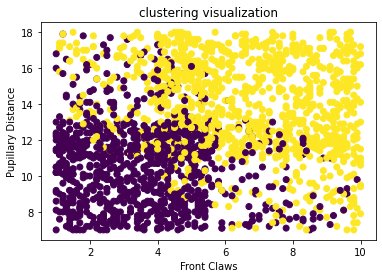

83.5


In [32]:
# clustering model
from pyspark.ml.clustering import KMeans 

kmeans = KMeans(k=2, seed=1)	
model = kmeans.fit(training)
data = model.transform(testing).toPandas()

plt.scatter(
    data["Front Claws"],
    data["Pupillary Distance"],
    c=data["prediction"]
)

# visualization
plt.title("clustering visualization")
plt.xlabel("Front Claws")
plt.ylabel("Pupillary Distance")
plt.show()

count = 0
for idx, row in data.iterrows():
  if row["Grizzly"] == row["prediction"]:
    count+=1
acc = count / len(data) * 100
print(acc)